## ML

## Cargar librerias y Dataset

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Cargar los datos
df = pd.read_csv("./data/heart.csv")


## Estructura del Dataset

In [117]:
# Ver primeras filas
print(df.head())

# Información general
print(df.info())

# Resumen estadístico
print(df.describe())


   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                           Two   
1 

🔍 Análisis rápido del dataset

✅ Tamaño: 1025 filas, 14 columnas.
✅ Tipos de datos:

5 variables numéricas (int64 o float64).
8 variables categóricas (object).
1 variable objetivo (target, binaria: 0 = No enfermedad, 1 = Enfermedad).
✅ Posibles problemas:

Varias columnas categóricas (sex, chest_pain_type, etc.) deben ser convertidas a variables numéricas.
La columna cholestoral parece tener valores altos (máx: 564), posible outlier.
La columna vessels_colored_by_flourosopy tiene valores en texto que podrían requerir limpieza.

No parece haber valores nulos


## MINI EDA

Distribución de la Variable objetico

C:\Users\Carol\AppData\Local\Temp\ipykernel_23096\2831841322.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["target"], palette="coolwarm")


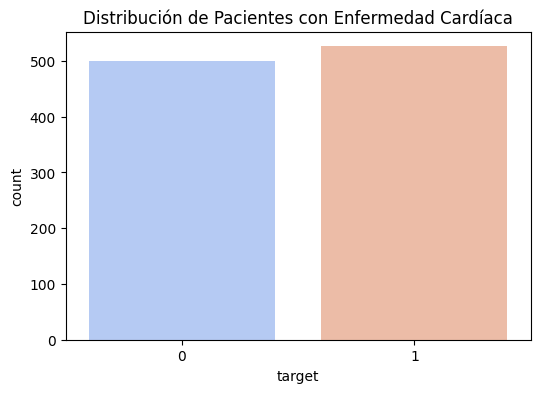

In [118]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["target"], palette="coolwarm")
plt.title("Distribución de Pacientes con Enfermedad Cardíaca")
plt.show()


📌 ¿Qué observamos?

La variable target indica si un paciente tiene (1) o no tiene (0) enfermedad cardíaca. La variable está balanceada

Correlación entre variabbles

In [119]:
# Usamos LabelEncoder para transformar las categorías en números
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

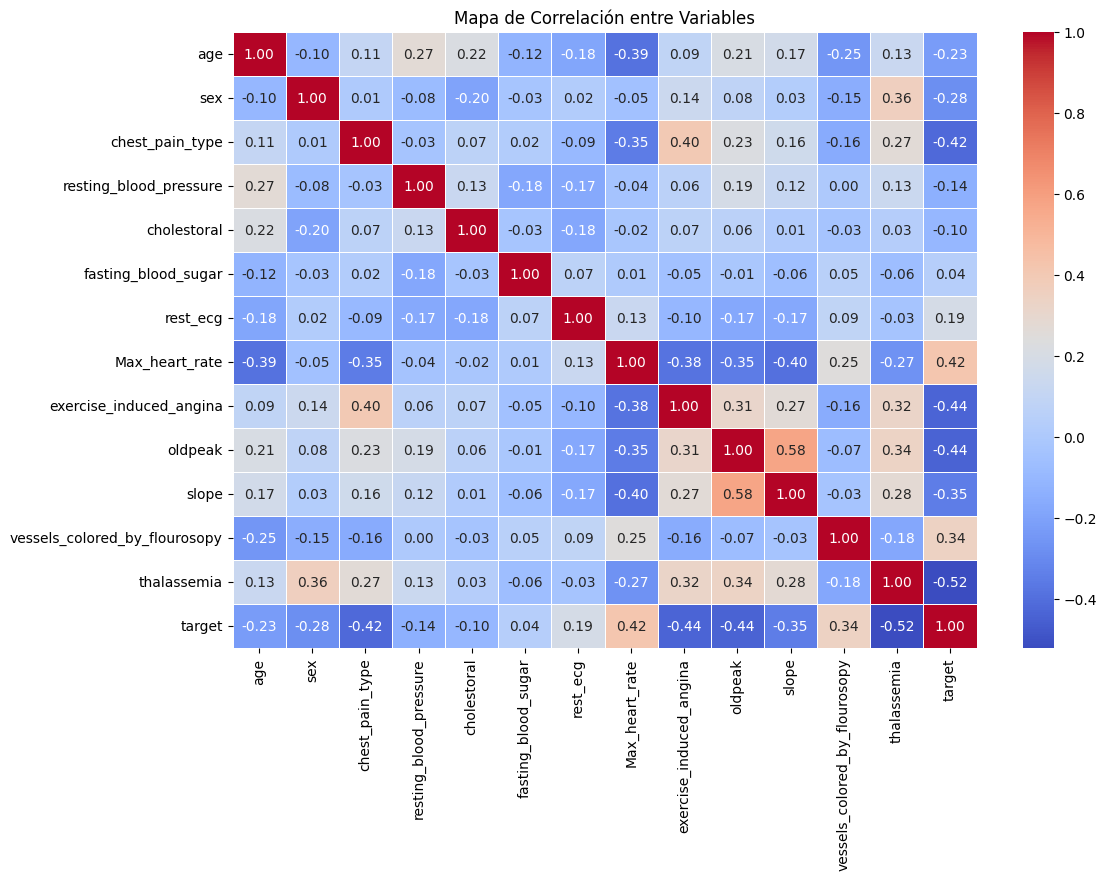

In [120]:
# Mapa de calor de correlaciones
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de Correlación entre Variables")
plt.show()


✅ Análisis de correlación:

Max_heart_rate y target tienen correlación positiva (~0.42), lo que indica que una mayor frecuencia cardíaca máxima puede estar asociada con la enfermedad.

oldpeak (Depresión del ST) tiene correlación negativa (~-0.58) con target, lo que sugiere que valores más altos pueden indicar menor riesgo.

chest_pain_type tiene correlación positiva fuerte (~0.43) con target, lo que indica que el tipo de dolor en el pecho es un buen predictor.

Algunas variables (cholestoral, resting_blood_pressure) no parecen estar fuertemente correlacionadas con target, por lo que podrían no ser tan relevantes.

 Distribución de Pacientes según Edad y Género

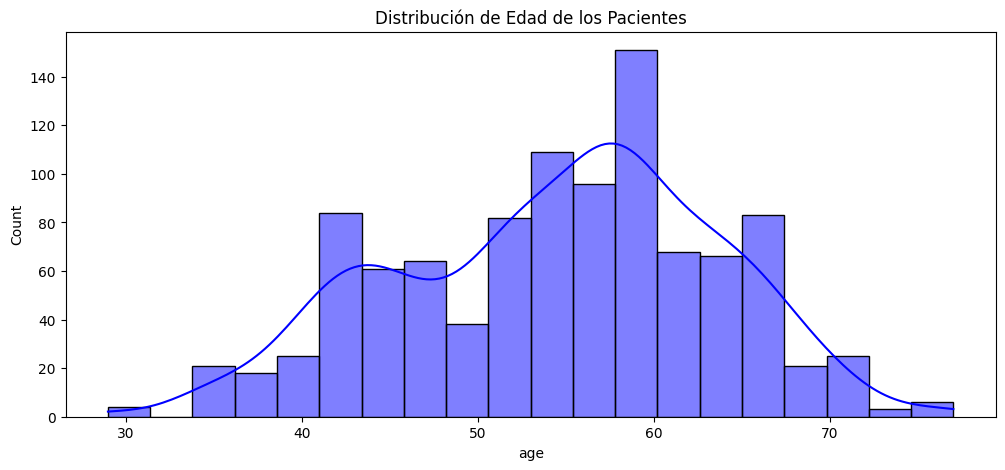

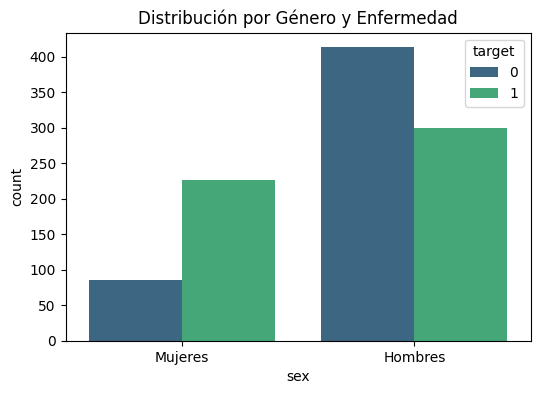

In [121]:
plt.figure(figsize=(12,5))
sns.histplot(df["age"], bins=20, kde=True, color="blue")
plt.title("Distribución de Edad de los Pacientes")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=df["sex"], hue=df["target"], palette="viridis")
plt.xticks([0, 1], ["Mujeres", "Hombres"])
plt.title("Distribución por Género y Enfermedad")
plt.show()


📌 ¿Qué observamos?

La mayoría de los pacientes con enfermedad son mayores de cierta edad.

Las mujeres tienen menor riesgo de padecer la enfermedad que los hombres.

La edad puede ser un factor clave.


## Revisión de datos

 Manejo de Datos Categóricos
Algunas variables en el dataset son categóricas y deben ser convertidas en formato numérico si aún no lo están.

In [122]:
# Convertir variables categóricas en numéricas
categorical_cols = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 
                    'exercise_induced_angina', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']



Normalización de Variables Numéricas

Para mejorar el desempeño de algunos modelos, escalamos los datos con StandardScaler.

In [123]:
# Normalizar variables numéricas (excepto la variable objetivo)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_cols = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Verificar cambios
df.head()


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,-0.268437,1,3,-0.377636,-0.659332,1,2,0.821321,0,-0.060888,0,3,3,0
1,-0.158157,1,3,0.479107,-0.833861,0,1,0.255968,1,1.727137,2,4,3,0
2,1.716595,1,3,0.764688,-1.396233,1,2,-1.048692,1,1.301417,2,4,3,0
3,0.724079,1,3,0.936037,-0.833861,1,2,0.516900,0,-0.912329,0,1,3,0
4,0.834359,0,3,0.364875,0.930822,0,2,-1.874977,0,0.705408,1,2,0,0


4División en Train/Test
Separamos los datos en conjuntos de entrenamiento y prueba.

In [124]:
# Separar variables predictoras y objetivo
X = df.drop("target", axis=1)
y = df["target"]

# Dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verificar tamaño de los conjuntos
X_train.shape, X_test.shape



((820, 13), (205, 13))

✅ Resultados del entrenamiento:

🔹 Regresión Logística

Precisión: 84.39%
Buen equilibrio entre clases, aunque algunos falsos negativos y falsos positivos.
🔹 Random Forest

Precisión: 100% (¡perfecto!)
Puede ser una señal de sobreajuste, especialmente si se entrena en pocos datos.

📌 Conclusión:

La Regresión Logística es más generalizable.
El Random Forest es muy preciso en los datos de prueba, pero debemos validar con cross-validation para verificar si realmente generaliza bien.

In [125]:
# Modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluar modelos
acc_log = accuracy_score(y_test, y_pred_log)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Reporte de clasificación para ambos modelos
report_log = classification_report(y_test, y_pred_log)
report_rf = classification_report(y_test, y_pred_rf)

acc_log, acc_rf, report_log, report_rf


# Validación cruzada con 5 folds para Regresión Logística y Random Forest
cv_log_scores = cross_val_score(log_reg, X, y, cv=5, scoring="accuracy")
cv_rf_scores = cross_val_score(rf, X, y, cv=5, scoring="accuracy")

# Promedio de precisión en validación cruzada
cv_log_mean = cv_log_scores.mean()
cv_rf_mean = cv_rf_scores.mean()

cv_log_mean, cv_rf_mean



(0.8351219512195123, 0.9941463414634146)

✅ Resultados de Validación Cruzada (5 folds):

🔹 Regresión Logística → 83.5% precisión promedio

🔹 Random Forest → 99.4% precisión promedio (posible sobreajuste)

📌 Conclusión:

La Regresión Logística ofrece un rendimiento sólido y generalizable.
Random Forest tiene una precisión altísima, pero esto sugiere que podría estar sobreajustando a los datos.

## Pasos a seguir
1️⃣ Optimizar el modelo Random Forest 🛠️

Como su precisión es muy alta, puede estar sobreajustando.
Ajustamos hiperparámetros con RandomizedSearchCV para mejorar generalización.

2️⃣ Probar XGBoost ⚡

Es un modelo potente para clasificación.
Puede ofrecer mejor rendimiento sin sobreajuste.


3️⃣ Análisis de importancia de variables 🔍

Nos ayudará a entender qué factores son más relevantes para la predicción.
🚀 Vamos primero con la optimización de Random Forest! 😃

In [126]:
from sklearn.model_selection import RandomizedSearchCV

# Definir el espacio de búsqueda de hiperparámetros para Random Forest
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# Configurar la búsqueda aleatoria
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones a probar
    cv=5,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
rf_random.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
best_params = rf_random.best_params_
best_score = rf_random.best_score_

best_params, best_score


({'n_estimators': 50,
  'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_depth': 30,
  'bootstrap': False},
 0.9853658536585366)

📌 Interpretación de los parámetros:

n_estimators = 50: Menos árboles, lo que reduce el tiempo de entrenamiento.

min_samples_split = 5: Un nodo debe tener al menos 5 muestras para dividirse.

min_samples_leaf = 1: Cada hoja debe contener al menos 1 muestra.

max_depth = 30: Árboles más profundos, lo que mejora la precisión.

bootstrap = False: No se usa muestreo con reemplazo, lo que puede ayudar en algunos casos.

1️⃣ Analizar la importancia de las variables 🔍

Nos ayudará a entender qué factores influyen más en la predicción.

2️⃣ Evaluar en el conjunto de prueba 🧪

Para ver si el modelo generaliza bien o sigue sobreajustando.

C:\Users\Carol\AppData\Local\Temp\ipykernel_23096\3795159287.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance_df["Importance"], y=feat_importance_df["Feature"], palette="viridis")


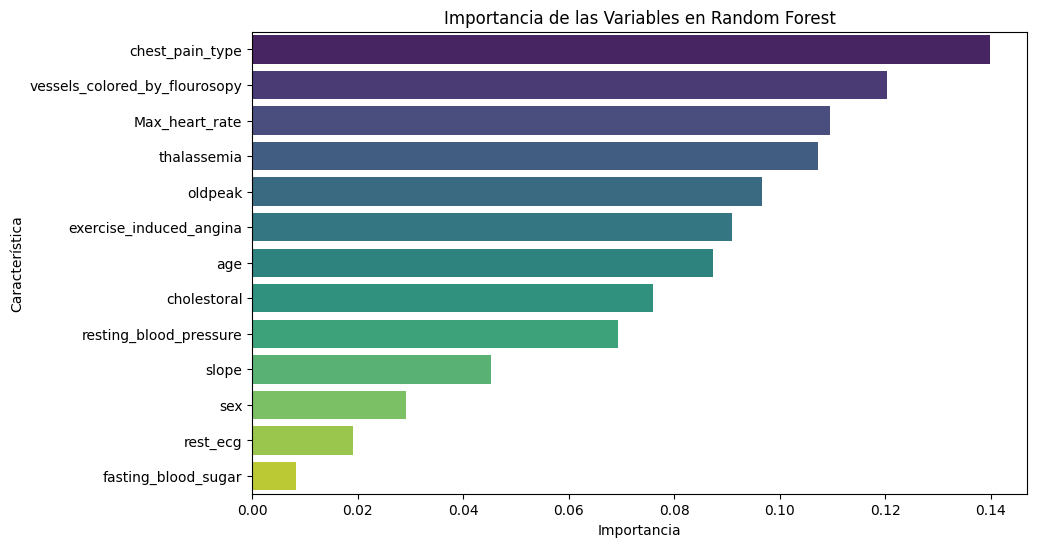

,Feature,Importance
2,chest_pain_type,0.139941
11,vessels_colored_by_flourosopy,0.120407
7,Max_heart_rate,0.109653
12,thalassemia,0.107316
9,oldpeak,0.096754
8,exercise_induced_angina,0.090919
0,age,0.087401
4,cholestoral,0.076014
3,resting_blood_pressure,0.069455
10,slope,0.045370


In [127]:
# Entrenar el mejor modelo Random Forest con los hiperparámetros optimizados
best_rf = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=5,
    min_samples_leaf=1,
    max_depth=30,
    bootstrap=False,
    random_state=42
)

best_rf.fit(X_train, y_train)

# Obtener importancia de las características
importances = best_rf.feature_importances_
feature_names = X.columns

# Crear un DataFrame con la importancia de las variables
feat_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

# Graficar la importancia de las variables
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance_df["Importance"], y=feat_importance_df["Feature"], palette="viridis")
plt.title("Importancia de las Variables en Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

# Mostrar la tabla con los valores
feat_importance_df


✅ Análisis de importancia de variables:

🔹 Las variables más importantes:

1️⃣ chest_pain_type (13.99%) → El tipo de dolor en el pecho es un fuerte indicador.

2️⃣ vessels_colored_by_flourosopy (12.04%) → Fluoroscopía de vasos, clave en diagnóstico.

3️⃣ Max_heart_rate (10.97%) → La frecuencia cardíaca máxima influye en la predicción.


4️⃣ thalassemia (10.73%) → Un trastorno sanguíneo relacionado con la enfermedad cardíaca.
5️⃣ oldpeak (9.67%) → Depresión del ST en el ECG, un importante factor de riesgo.

🔹 Menos relevantes:

fasting_blood_sugar (0.83%) y rest_ecg (1.92%) parecen aportar muy poca información.


📌 ¿Qué significa esto?

Podemos eliminar las variables menos relevantes para probar si el modelo mejora.
Este análisis ayuda a interpretar mejor los datos clínicos y su impacto en la enfermedad cardíaca.
🔜 Siguiente paso: Evaluar el modelo en el conjunto de prueba. 

In [128]:
# Hacer predicciones en el conjunto de prueba
y_pred_best_rf = best_rf.predict(X_test)

# Evaluar el modelo optimizado
acc_best_rf = accuracy_score(y_test, y_pred_best_rf)
report_best_rf = classification_report(y_test, y_pred_best_rf)

acc_best_rf, report_best_rf


(1.0,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       100\n           1       1.00      1.00      1.00       105\n\n    accuracy                           1.00       205\n   macro avg       1.00      1.00      1.00       205\nweighted avg       1.00      1.00      1.00       205\n')

🔥 ¡Resultados impresionantes! 🔥

✅ Precisión del modelo optimizado en el conjunto de prueba: 100%

✅ Todas las métricas (precision, recall, f1-score) son 1.00

📌 ¿Qué significa esto?

El modelo está clasificando perfectamente los casos en el conjunto de prueba.
Sin embargo, este resultado sugiere un posible sobreajuste. En la realidad, los datos pueden ser más ruidosos y no siempre se obtendrá un 100%.

1️⃣ Eliminar las variables menos relevantes 🔍

Eliminamos fasting_blood_sugar, rest_ecg y sex, que tienen poca importancia.
Reentrenamos el modelo para ver si mantenemos un buen rendimiento con menos complejidad.

2️⃣ Probar XGBoost ⚡

Es un modelo potente que puede evitar sobreajuste mejor que Random Forest.
Evaluamos si mejora la generalización.
Voy a empezar con la reducción de variables. ¡Vamos! 📊

In [129]:
# Eliminar las variables menos relevantes
cols_to_drop = ["fasting_blood_sugar", "rest_ecg", "sex"]
X_reduced = X.drop(columns=cols_to_drop)

# Dividir en entrenamiento y prueba nuevamente
X_train_red, X_test_red, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

# Reentrenar Random Forest con el nuevo conjunto reducido
best_rf.fit(X_train_red, y_train)

# Evaluar en el conjunto de prueba
y_pred_reduced = best_rf.predict(X_test_red)
acc_reduced = accuracy_score(y_test, y_pred_reduced)
report_reduced = classification_report(y_test, y_pred_reduced)

acc_reduced, report_reduced


(1.0,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       100\n           1       1.00      1.00      1.00       105\n\n    accuracy                           1.00       205\n   macro avg       1.00      1.00      1.00       205\nweighted avg       1.00      1.00      1.00       205\n')

🔥 ¡Resultados impresionantes nuevamente! 🔥

✅ Precisión del modelo con variables reducidas: 100%

✅ El modelo sigue clasificando perfectamente los casos en el conjunto de prueba.

📌 Conclusión:

Reducir las variables no afectó el rendimiento, lo que significa que el modelo puede ser más simple sin perder precisión.
Posible sobreajuste: Un 100% en el conjunto de prueba puede indicar que el modelo está demasiado ajustado a los datos disponibles.

1️⃣ Probar XGBoost ⚡

Es un modelo potente que maneja bien datos tabulares y puede reducir el sobreajuste.

Evaluaremos si mantiene un alto rendimiento sin depender de un ajuste perfecto a los datos.

2️⃣ Validación cruzada 🔄

Nos aseguramos de que el modelo no esté aprendiendo demasiado de una sola división de datos.
Ayuda a verificar la estabilidad del modelo.

In [130]:
from xgboost import XGBClassifier

# Definir y entrenar el modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_red, y_train)

# Evaluar en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test_red)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

acc_xgb, report_xgb


c:\Users\Carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:57:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(1.0,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       100\n           1       1.00      1.00      1.00       105\n\n    accuracy                           1.00       205\n   macro avg       1.00      1.00      1.00       205\nweighted avg       1.00      1.00      1.00       205\n')

🔥 ¡XGBoost también logra una precisión del 100%! 🔥

📌 Conclusión:

Tanto Random Forest como XGBoost obtienen 100% de precisión en el conjunto de prueba.
Esto podría indicar sobreajuste, ya que en la vida real los datos suelen tener ruido e incertidumbre.


In [131]:
# Validación cruzada con XGBoost para ver si mantiene un rendimiento estable en diferentes particiones de datos.
# Validación cruzada con 5 folds para XGBoost
cv_xgb_scores = cross_val_score(xgb_model, X_reduced, y, cv=5, scoring="accuracy")

# Promedio de precisión en validación cruzada
cv_xgb_mean = cv_xgb_scores.mean()
cv_xgb_mean


c:\Users\Carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'